# Q1. LQR $[70 pts]$
## Task1 : LQR algorithm $[20 pts]$

Complete the backward part of the LQR algorithm

$$K_n=-\left(R+B^{\text{T}}P_{n-1}B\right)^{-1}B^{\text{T}}P_{n-1}A$$

$$P_n=Q+K^{\text{T}}_{n}RK_{n}+\left(A+BK_{n}\right)^{\text{T}}P_{n-1}\left(A+BK_{n}\right)$$

Ref) Optimal Control to RL (UofT CSC26t21) Lecture Note

In [62]:
import scipy
import numpy as np
from math import sin, cos, pi
import matplotlib
import matplotlib.pyplot as plt

class LQR(object):
    def __init__(self, A, B, Q, R):
        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        
    def compute_policy_gains(self, T, dt):
        if type(self.A) != type([]):
            self.A = T*[self.A] 

        if type(self.B) != type([]):
            self.B = T*[self.B] 
            
        self.P = (T+1)*[self.Q]
        self.K = (T+1)*[0]
        
        for t in range(1, T + 1):
            ##########################################
            # Task1: fill your code here
            # Update self.P, self.K through backward LQR algorithm
            ##########################################
            self.K[t] = -np.linalg.inv(self.R + np.transpose(self.B[T-t])@self.P[t-1]@self.B[T-t])@np.transpose(self.B[T-t])@self.P[t-1]@self.A[T-t]
            self.P[t] = self.Q + np.transpose(self.K[t])@self.R@self.K[t]+np.transpose(self.A[T-t] + self.B[T-t]@self.K[t])@self.P[t-1]@(self.A[T-t] + self.B[T-t]@self.K[t])
        
        self.K = self.K[1:]
        self.K = self.K[::-1]
        self.P = self.P[::-1]
        return self.K

## Task2: Omnidirectional vehicle with friction $[25 pts]$

$$m\ddot{\mathbf{p}}=\mathbf{u}-\alpha\dot{\mathbf{p}}$$
where $m$ is a force applied to the vehicle, $\mathbf{u}$ is a control applied to the vehicle, and $\alpha$ is a friction opposed to motion. Set $\dot{\mathbf{p}}=\mathbf{v}$ and discretize by setting
$${{\mathbf{p}_{t+1}-\mathbf{p}_{t}}\over{\delta t}}\simeq\mathbf{v}_{t}$$
$$m{{\mathbf{v}_{t+1}-\mathbf{v}_{t}}\over{\delta t}}\simeq\mathbf{u}_{t}-\alpha\mathbf{v}_{t}$$
and definte the state vector $\mathbf{x}_{t}=\begin{bmatrix}\mathbf{p}_{t} \\ \mathbf{v}_{t}\end{bmatrix}$. Then, the linear system is expressed as:
$$\mathbf{x}_{t+1}=\begin{bmatrix}1 & 0 & \delta t & 0 \\ 0 & 1 & 0 & \delta t \\ 0& 0& 1-\alpha\delta t/m & 0 \\ 0 & 0 & 0 & 1-\alpha\delta t/m\end{bmatrix}\mathbf{x}_{t}+\begin{bmatrix}0 & 0 \\ 0 & 0 \\ {{\delta t}\over{m}} & 0 \\ 0 & {{\delta t}\over{m}}\end{bmatrix}\mathbf{u}_{t}$$
with initial state
$$\mathbf{x}_{0}=\begin{bmatrix}10\\30\\10\\-5\end{bmatrix}$$
instantaneous cost function
$$c(\mathbf{x}, \mathbf{u})=||\mathbf{x}||^{2}+100||\mathbf{u}||^{2}$$

- Complete the omnidirectional vehicle with friction where $T=2500$, $dt=0.01$, $m=1$, and $\alpha=0.1$.

- Complete the foward part of the LQR algorithm

Ref) Optimal Control to RL (UofT CSC26t21) Lecture Note

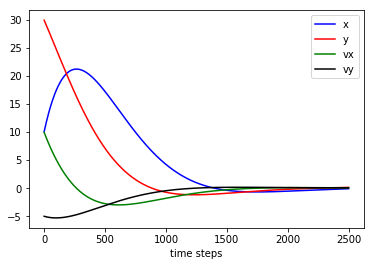

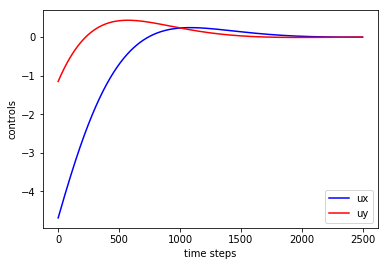

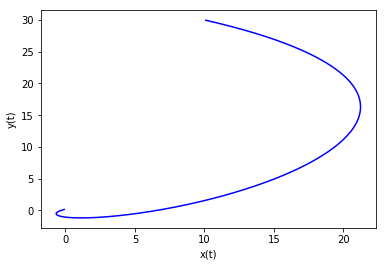

In [75]:
T = 2500
dt = 0.01
mass = 1.0
friction = 0.1

# State vector = [x, y, vx, vy]
x_init = np.array([10, 30, 10, -5.0], dtype='float64').transpose()

##########################################
# Task2-1: fill your code here
# Define the input matrix A, B, Q, and R
##########################################
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt], 
              [0, 0, 1 - friction*dt/mass, 0],
              [0, 0, 0, 1 - friction*dt/mass]], dtype='float64')
B = np.array([[0, 0, dt/mass, 0], [0, 0, 0, dt/mass]], dtype='float64').transpose()
Q = np.identity(4)
R = 100 * np.identity(2)

lqr = LQR(A,B,Q,R)
K = lqr.compute_policy_gains(T, dt)

x = x_init
X = np.zeros((T, 4), dtype='float64')
U = np.zeros((T, 2), dtype='float64')

for i in range(T):
    ##########################################
    # Task2-2: fill your code here
    # Update u and x through LQR forward algorithm
    ##########################################
    u = K[i]@x
    x = A@x + B@u
    X[i, :] = x.transpose()
    U[i, :] = u.transpose()
    
plt.figure()
plt.plot( X[:, 0], '-b')
plt.plot( X[:, 1], '-r')
plt.plot( X[:, 2], '-g')
plt.plot( X[:, 3], '-k')
plt.legend(['x', 'y', 'vx', 'vy'])
plt.xlabel('time steps')
plt.show()


plt.figure()
plt.plot( U[:, 0], 'b')
plt.plot( U[:, 1], 'r')
plt.legend(['ux', 'uy'])
plt.xlabel('time steps')
plt.ylabel('controls')
plt.show()

plt.figure()
plt.plot( X[:, 0], X[:, 1], 'b')
plt.xlabel('x(t)')
plt.ylabel('y(t)')

plt.show()

## Task3: Trajectory following for Omnidirectional vehicle with friction $[25 pts]$

$$m\ddot{\mathbf{p}}=\mathbf{u}-\alpha\dot{\mathbf{p}}$$
where $m$ is a force applied to the vehicle, $\mathbf{u}$ is a control applied to the vehicle, and $\alpha$ is a friction opposed to motion. Set $\dot{\mathbf{p}}=\mathbf{v}$ and discretize by setting
$${{\mathbf{p}_{t+1}-\mathbf{p}_{t}}\over{\delta t}}\simeq\mathbf{v}_{t}$$
$$m{{\mathbf{v}_{t+1}-\mathbf{v}_{t}}\over{\delta t}}\simeq\mathbf{u}_{t}-\alpha\mathbf{v}_{t}$$
and definte the state vector $\mathbf{x}_{t}=\begin{bmatrix}\mathbf{p}_{t} \\ \mathbf{v}_{t}\end{bmatrix}$. Then, the linear system is expressed as:
$$\mathbf{x}_{t+1}=\begin{bmatrix}1 & 0 & \delta t & 0 \\ 0 & 1 & 0 & \delta t \\ 0& 0& 1-\alpha\delta t/m & 0 \\ 0 & 0 & 0 & 1-\alpha\delta t/m\end{bmatrix}\mathbf{x}_{t}+\begin{bmatrix}0 & 0 \\ 0 & 0 \\ {{\delta t}\over{m}} & 0 \\ 0 & {{\delta t}\over{m}}\end{bmatrix}\mathbf{u}_{t}$$

We are given a desired trajectory
$$\mathbf{p}^{*}_{0}, \mathbf{p}^{*}_{1}, \cdots, \mathbf{p}^{*}_{T}$$

with initial state
$$\mathbf{x}_{0}=\begin{bmatrix}10\\30\\0\\0\end{bmatrix}$$
instantaneous cost function
$$c(\mathbf{x}, \mathbf{u})=(\mathbf{p}_{t}-\mathbf{p}_{t}^{*})^{\text{T}}(\mathbf{p}_{t}-\mathbf{p}_{t}^{*})+||\mathbf{u}||^{2}$$

- Redefine state $z$, matrix $\bar{A}$, $\bar{B}$, and cost function using $\mathbf{x}$, $\mathbf{A}$, $\mathbf{B}$, $\mathbf{Q}$, and $\mathbf{R}$.

- Complete the trajectory following for omnidirectional vehicle with friction where $T=2500$, $dt=0.01$, $m=1$, and $\alpha=0.1$.

- Complete the foward part of the LQR algorithm

Ref) Optimal Control to RL (UofT CSC26t21) Lecture Note

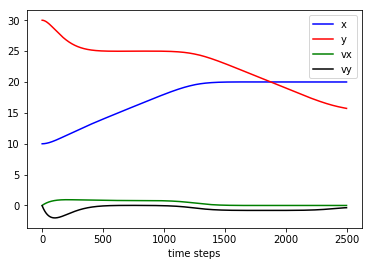

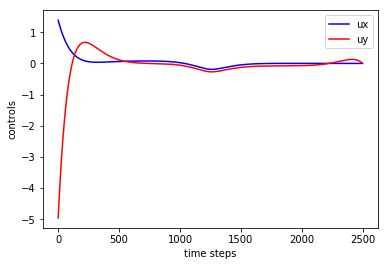

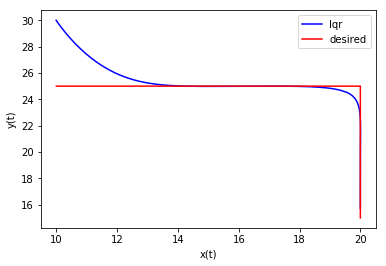

In [104]:
T = 2500
dt = 0.01
mass = 1.0
friction = 0.1

# Desired trajectory: p_star
p_star_1 = np.array([10 + np.linspace(0,10, 1250), 25.0*np.ones((1,1250))[0] ])
p_star_2 = np.array([20.0*np.ones((1,1251))[0], 25.0 - np.linspace(0, 10, 1251) ])
p_star = np.concatenate([p_star_1, p_star_2], axis=1)

# State vector = [x, y, vx, vy]
x_init = np.array([10, 30, 0, .0], dtype='float64').transpose()
x_star_init = np.array([p_star[0, 0], p_star[1, 0], 0.0, 0.0])
z_init = np.concatenate([x_init - x_star_init, np.array([1])])

##########################################
# Task3-1: fill your code here
# Define the input matrix A, B, Q, and R
##########################################
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt], 
              [0, 0, 1 - friction*dt/mass, 0],
              [0, 0, 0, 1 - friction*dt/mass]], dtype='float64')
B = np.array([[0, 0, dt/mass, 0], [0, 0, 0, dt/mass]], dtype='float64').transpose()
Q = np.zeros(shape=(5, 5))
Q[0, 0] = 1
Q[1, 1] = 1
# Q = np.identity(5)  c(x, u) = ||z||^2 +||u||^2
R = np.identity(2)

A_bar = []
for t in range(T):
    ##########################################
    # Task3-2: fill your code here
    # Define A_bar using A and p_star
    ##########################################
    x_star = np.array([p_star[0, t], p_star[1, t], 0.0, 0.0])
    next_x_star = np.array([p_star[0, t+1], p_star[1, t+1], 0.0, 0.0])
    c = A@x_star - next_x_star
    A_bar.append(np.zeros(shape=(5, 5)))
    A_bar[t][:4, :4] = A
    A_bar[t][:4, 4] = c
    A_bar[t][4, 4] = 1
    
##########################################
# Task3-3: fill your code here
# Define B_bar using B
##########################################
B_bar = np.zeros((5, 2))
B_bar[:4, :2] = B


lqr = LQR(A_bar, B_bar, Q, R)
K = lqr.compute_policy_gains(T, dt)

x = x_init
z = z_init
X = np.zeros((T, 4), dtype='float64')
U = np.zeros((T, 2), dtype='float64')

for i in range(T):
    ##########################################
    # Task3-4: fill your code here
    # Update x, u and z through LQR forward algorithm
    ##########################################
    u = K[i]@z
    z = A_bar[i]@z + B_bar@u    
    x = z[:4] + np.array([p_star[0, i], p_star[1, i], 0.0, 0.0])
    X[i, :] = x.transpose()
    U[i, :] = u.transpose()


plt.figure()
plt.plot( X[:, 0], '-b')
plt.plot( X[:, 1], '-r')
plt.plot( X[:, 2], '-g')
plt.plot( X[:, 3], '-k')
plt.legend(['x', 'y', 'vx', 'vy'])
plt.xlabel('time steps')
plt.show()


plt.figure()
plt.plot( U[:, 0], 'b')
plt.plot( U[:, 1], 'r')
plt.legend(['ux', 'uy'])
plt.xlabel('time steps')
plt.ylabel('controls')
plt.show()

plt.figure()
plt.plot( X[:, 0], X[:, 1], 'b')
plt.plot( p_star[0, :], p_star[1, :], 'r')
plt.xlabel('x(t)')
plt.ylabel('y(t)')
plt.legend(['lqr', 'desired'])
plt.show()